# GAN-neuroverkon hyödyntäminen datan generoinnissa

Tämän pilotin tarkoituksena on demonstroida GAN neuroverkon hyödyntämistä tilanteessa, jossa dataa on saatavilla vähän, mutta sitä tarvitaan enemmän esimerkiksi keinoäly algoritmin koulututtamiseksi.

Pilotti on toteutettu osana "Datasta ketteryyttä ja uutta liiketoimintaa Etelä-Pohjanmaan pk-yrityksiin (TehoData)" -hanketta.
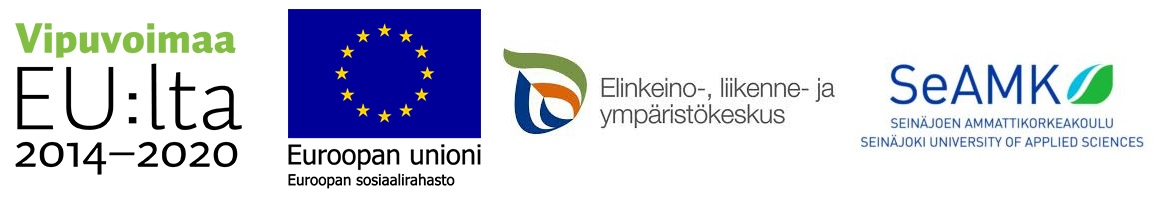

In [12]:
# Author: Ari Sivula

# Import libraries
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from ctgan import CTGANSynthesizer
from keras.layers import Dense
from keras.models import Sequential
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [13]:
# Read the data and preprocess
df = pd.read_csv('DATA1.csv', sep = ';', decimal=',', header=None)

''' Pre-process the data '''
# Drop not required columns
df.drop(0, axis=1, inplace=True)
df.drop(1, axis=1, inplace=True)
df.drop(3, axis=1, inplace=True)
df.drop(4, axis=1, inplace=True)
df.drop(10, axis=1, inplace=True)
df.drop(13, axis=1, inplace=True)
df.drop(27, axis=1, inplace=True)

# Reset indexes
df.index, df.columns = [range(df.index.size), range(df.columns.size)]

# Convert columns
df[0] = pd.to_datetime(df[0]).dt.date

df[8] = df[8].replace({" ap.": " AM"}, regex=True)
df[8] = df[8].replace({" ip.": " PM"}, regex=True)
df[9] = df[9].replace({" ap.": " AM"}, regex=True)
df[9] = df[9].replace({" ip.": " PM"}, regex=True)
df[10] = df[10].replace({" ap.": " AM"}, regex=True)
df[10] = df[10].replace({" ip.": " PM"}, regex=True)
df[11] = df[11].replace({" ap.": " AM"}, regex=True)
df[11] = df[11].replace({" ip.": " PM"}, regex=True)
df[15] = df[15].replace({" ap.": " AM"}, regex=True)
df[15] = df[15].replace({" ip.": " PM"}, regex=True)
df[16] = df[16].replace({" ap.": " AM"}, regex=True)
df[16] = df[16].replace({" ip.": " PM"}, regex=True)

timeformat = '%H:%M %p'
df[8] = pd.to_datetime(df[8], format=timeformat)
df[9] = pd.to_datetime(df[9], format=timeformat)
df[10] = pd.to_datetime(df[10], format=timeformat).dt.time
df[11] = pd.to_datetime(df[11], format=timeformat).dt.time
df[15] = pd.to_datetime(df[15], format=timeformat).dt.time
df[16] = pd.to_datetime(df[16], format=timeformat).dt.time

# Encoding
le_1 = LabelEncoder()
df['En_1'] = le_1.fit_transform(df[1])
le_6 = LabelEncoder()
df['En_6'] = le_6.fit_transform(df[6])

# Drop rest
df.drop(1, axis=1, inplace=True)
df.drop(6, axis=1, inplace=True)

# Calculate the amount in minutes
df['TimeM'] = (df[8] - df[9]).astype('timedelta64[m]')
df[8] = pd.to_datetime(df[8], format=timeformat).dt.time
df[9] = pd.to_datetime(df[9], format=timeformat).dt.time

# Impute the rest values with mean and drop
df[19].fillna(df[19].mean(), inplace = True)
df[13].fillna(df[13].mean(), inplace = True)
df[17].fillna(df[17].mean(), inplace = True)
df[18].fillna(df[18].mean(), inplace = True)
df[20].fillna(df[20].mean(), inplace = True)
df[14].fillna(df[14].mean(), inplace = True)
df[13].fillna(df[13].mean(), inplace = True)
df['TimeM'].fillna(df['TimeM'].median(), inplace = True)
df.dropna(inplace=True)

# Normalize the data excluding the discreate variables
min_max_scaler = preprocessing.MinMaxScaler()
df[[2, 3, 4, 5, 7, 12, 13, 14, 17, 18, 19, 20, "TimeM"]] = min_max_scaler.fit_transform(df[[2, 3, 4, 5, 7, 12, 13, 14, 17, 18, 19, 20, "TimeM"]])

# Drop not required
df.drop(0, axis=1, inplace=True)
df.drop(8, axis=1, inplace=True)
df.drop(9, axis=1, inplace=True)
df.drop(10, axis=1, inplace=True)
df.drop(11, axis=1, inplace=True)
df.drop(15, axis=1, inplace=True)
df.drop(16, axis=1, inplace=True)

In [14]:
# Generate synthetic data (GAN) to extend the sample
discrete_columns = [
    'En_1',
    'En_6',
    'TimeM'
]

ctgan = CTGANSynthesizer(epochs=10)
ctgan.fit(df, discrete_columns)

# Generate synthetic data
synthetic_df = ctgan.sample(10000)

In [15]:
# Generate ANN to test the usability of GAN network data
X = synthetic_df.iloc[:, 1:15].values
y = synthetic_df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Train using the train data
model = Sequential()
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mean_squared_error'])

# Fit
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./nn_summaries")
model.fit(X_train, y_train, epochs=50, batch_size=5, callbacks=[tensorboard_callback])

Epoch 1/50
1340/1340 [==============================] - 1s 724us/step - loss: 1.2162 - mean_squared_error: 0.4216
Epoch 2/50
1340/1340 [==============================] - 1s 523us/step - loss: 0.5840 - mean_squared_error: 0.0253
Epoch 3/50
1340/1340 [==============================] - 1s 479us/step - loss: 0.5755 - mean_squared_error: 0.0220
Epoch 4/50
1340/1340 [==============================] - 1s 481us/step - loss: 0.5732 - mean_squared_error: 0.0211
Epoch 5/50
1340/1340 [==============================] - 1s 473us/step - loss: 0.5719 - mean_squared_error: 0.0206
Epoch 6/50
1340/1340 [==============================] - 1s 496us/step - loss: 0.5711 - mean_squared_error: 0.0202
Epoch 7/50
1340/1340 [==============================] - 1s 476us/step - loss: 0.5701 - mean_squared_error: 0.0199
Epoch 8/50
1340/1340 [==============================] - 1s 477us/step - loss: 0.5696 - mean_squared_error: 0.0197
Epoch 9/50
1340/1340 [==============================] - 1s 488us/step - loss: 0.5690 - m

In [16]:
# Evaluate using the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Mean Squared Error (accuracy, Mean Squared Error): %.5f' % test_accuracy)
print('Test loss: %.5f' % test_loss)

# Evaluate using the real data
r_X = df.iloc[:, 1:15].values
r_y = df.iloc[:, 0].values
r_test_loss, r_test_accuracy = model.evaluate(r_X, r_y)
print('Mean Squared Error with real data (accuracy, Mean Squared Error): %.5f' % r_test_accuracy)

104/104 [==============================] - 0s 557us/step - loss: 0.5718 - mean_squared_error: 0.0179
Mean Squared Error (accuracy, Mean Squared Error): 0.01792
Test loss: 0.57177
15/15 [==============================] - 0s 1ms/step - loss: 0.6539 - mean_squared_error: 0.0253
Mean Squared Error with real data (accuracy, Mean Squared Error): 0.02527
